In [1]:
import torch

from transformers import AutoModelForCausalLM, pipeline, GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

import numpy as np
import sympy as sp
import json

In [2]:
from model.tokens import Token, TOKEN_TYPE_EXPRESSIONS, TOKEN_TYPE_ANSWERS
from model.equation_interpreter import Equation
from model.vocabulary import Vocabulary
from model.tokens import Token

In [3]:
from datasets import disable_caching
disable_caching()

In [4]:
# Create a combined vocabulary
vocabulary = Vocabulary.construct_from_list(TOKEN_TYPE_EXPRESSIONS + TOKEN_TYPE_ANSWERS)

# Global variables
model_name = "JustSumAI"
project_name = "JustSumAI"
repo_name = f"{model_name}_cleaned_gpt2_data"

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

input_text = "This is my input sequence."
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids, input_ids.size()

(tensor([[1212,  318,  616, 5128, 8379,   13]]), torch.Size([1, 6]))

In [6]:
vocabulary.end_seq_index

65

# Load model

In [7]:
model = GPT2LMHeadModel.from_pretrained(f"Dragonoverlord3000/{model_name}", force_download=True)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(68, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=68, bias=False)
)

In [8]:
test_example_ids = torch.LongTensor([vocabulary.vectorize(["#", "/", "0", "0"])[:-1] + [vocabulary.separator_index]])
test_example_ids[0], test_example_ids.size()

(tensor([64, 40, 39, 19, 19, 67]), torch.Size([1, 6]))

In [9]:
test = model(test_example_ids).logits
print(test.size())
[vocabulary.getToken(torch.argmax(o).item()) for o in test[0]]

torch.Size([1, 6, 68])


['<BEGIN>', '#', '/', '0', '0', 'TT_ZERO']

In [10]:
out = model.generate(test_example_ids, 
                     eos_token_id=vocabulary.end_seq_index, 
                     pad_token_id=vocabulary.mask_index)
out, out.size()

/opt/homebrew/lib/python3.11/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (227) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


(tensor([[64, 40, 39, 19, 19, 67, 51, 49, 59, 49, 57, 60, 59, 49, 61, 65]]),
 torch.Size([1, 16]))

In [11]:
l = [vocabulary.getToken(o.item()) for o in out[0]]
l, l.index("[SEP]")

(['<BEGIN>',
  '#',
  '/',
  '0',
  '0',
  '[SEP]',
  'TT_ZERO',
  'TT_INTEGER',
  'TT_MINUS',
  'TT_INTEGER',
  'TT_LOG',
  'TT_MULTIPLY',
  'TT_MINUS',
  'TT_INTEGER',
  'TT_DIVIDE',
  '<END>'],
 5)

In [12]:
eq = Equation([Token(vocabulary.getToken(o.item())) for o in out[0]][l.index("[SEP]")+1:-1], notation="postfix")
eq.tokenized_equation

[---- Type: TT_ZERO 	 Value: None ----,
 ---- Type: TT_INTEGER 	 Value: None ----,
 ---- Type: TT_MINUS 	 Value: None ----,
 ---- Type: TT_INTEGER 	 Value: None ----,
 ---- Type: TT_LOG 	 Value: None ----,
 ---- Type: TT_MULTIPLY 	 Value: None ----,
 ---- Type: TT_MINUS 	 Value: None ----,
 ---- Type: TT_INTEGER 	 Value: None ----,
 ---- Type: TT_DIVIDE 	 Value: None ----]

In [13]:
# eq.getMathemetaicalNotation()

______

In [14]:
#sp.parse_expr(eq.getMathemetaicalNotation(), evaluate=False)

# Embedding Weights

In [15]:
word_embeddings = model.transformer.wte.weight  # Word Token Embeddings 
position_embeddings = model.transformer.wpe.weight  # Word Position Embeddings 

In [16]:
word_embeddings, word_embeddings.shape

(Parameter containing:
 tensor([[ 0.1379, -0.0895,  0.0899,  ...,  0.0524,  0.0685, -0.0181],
         [ 0.1699, -0.1127,  0.0541,  ...,  0.0788,  0.0758, -0.0116],
         [ 0.1594, -0.1452,  0.0274,  ...,  0.0764,  0.0662, -0.0057],
         ...,
         [ 0.1688, -0.0346, -0.0128,  ...,  0.0282,  0.0424, -0.1646],
         [-0.0100, -0.0673, -0.0655,  ..., -0.0254,  0.0665,  0.0343],
         [ 0.0542,  0.0733, -0.0143,  ..., -0.0334,  0.0559,  0.0573]],
        requires_grad=True),
 torch.Size([68, 768]))

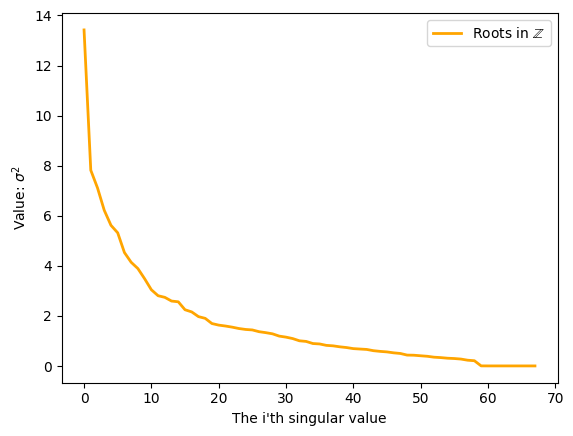

In [17]:
U,D,V = np.linalg.svd(word_embeddings.detach().numpy())
plt.xlabel("The i'th singular value")
plt.ylabel(r"Value: $\sigma^2$")
plt.plot(D, color="orange", linewidth=2)
plt.legend(["Roots in $\mathbb{Z}$"])

In [18]:
# with open("Qwordembeds.txt", "w") as f:
#     f.write(json.dumps(word_embeddings.detach().numpy().tolist()))
# f.close()

### Accept user input

In [19]:
from IPython.display import display
import ipywidgets as widgets

In [20]:
numerator_degree = 3
denominator_degree = 6

In [21]:
def parentherizer(val):
    if "-" in val:
        return f"({val})"
    return val

In [22]:
math_display = widgets.HTMLMath(
    value=f"Sum Math",
    placeholder='',
    description='',
)

numerator_list = [widgets.SelectionSlider(
    options=TOKEN_TYPE_EXPRESSIONS[:-2],
    value='-5',
    description=f'Root {i+1}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
) for i in range(numerator_degree)]

denominator_list = [
    widgets.SelectionSlider(
    options=TOKEN_TYPE_EXPRESSIONS[:-2],
    value='-5',
    description=f'Root {i+1}',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
) for i in range(denominator_degree)]

ui_1 = widgets.VBox(numerator_list)
ui_2 = widgets.VBox(denominator_list)

def f(**kwargs):
#     print(kwargs, list(kwargs))
    sum_str = r"$$\sum_{n=1}^{\infty}\frac{" + "".join([f"(n - {parentherizer(kwargs[str(i)])})" for i in range(numerator_degree)]) + "}{" + "".join([f"(n - {parentherizer(kwargs[str(i + numerator_degree)])})" for i in range(denominator_degree)]) + "}" + "$$"
    math_display.value = sum_str
    display(math_display)

out = widgets.interactive(f, **{str(i):v for i,v in enumerate(numerator_list + denominator_list)})

display(out)#ui_1, ui_2, out)

HTMLMath(value='$$\\sum_{n=1}^{\\infty}\\frac{(n - (-5))(n - (-5))(n - (-5))}{(n - (-5))(n - (-5))(n - (-5))(n…

interactive(children=(SelectionSlider(continuous_update=False, description='Root 1', options=('-5', '-4', '-3'…

In [23]:
[v.value for v in numerator_list]

['-5', '-5', '-5']

In [24]:
input_sum = vocabulary.vectorize(
    [v.value for v in numerator_list] + ["/"] + [v.value for v in denominator_list]
)[:-1] + [vocabulary.separator_index]
input_sum = torch.LongTensor([input_sum])
out = model.generate(input_sum,
                    eos_token_id=vocabulary.end_seq_index, 
                    pad_token_id=vocabulary.mask_index)
pred = [vocabulary.getToken(o.item()) for o in out[0]]
pred

['<BEGIN>',
 '-5',
 '-5',
 '-5',
 '/',
 '-5',
 '-5',
 '-5',
 '-5',
 '-5',
 '-5',
 '[SEP]',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_EULERGAMMA',
 'TT_MULTIPLY',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_EULERGAMMA',
 'TT_MULTIPLY',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_DIVIDE',
 'TT_PLUS',
 'TT_INTEGER',
 'TT_INTEGER',
 'TT

In [25]:
eq = Equation([Token(p) for p in pred][pred.index("[SEP]")+1:-1], notation="postfix")
eq.getMathmetaicalNotation()

AttributeError: 'Equation' object has no attribute 'getMathmetaicalNotation'